In [1]:
#############################################################################################
# The code is running with Tensroflow 1.15 
# on docker tensorflow/tensorflow:1.15.0-gpu-py3 (with additional packages: scikit/scikit-image/keras)
# And I add import tensorflow.compatv1 as tf in the original project
#############################################################################################
# I met
# Error : Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
# https://github.com/tensorflow/tensorflow/issues/24828
# Suggests the following solution

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config0 = ConfigProto()
config0.gpu_options.allow_growth = True
#for multiple GPUs
config0.allow_soft_placement=True
session = InteractiveSession(config=config0)

####################################################################

# return a list of the file nmaes in the dirtory
from os import listdir
# extracting bounding boxes from an annotation file
#to get the treee from the xml file
from xml.etree import ElementTree 
from numpy import zeros
from numpy import asarray
# Dataset is a class defined in the project
# We need to define load_dataset / load_mask / image_refernce by ourselves
from mrcnn.utils import Dataset # DIfferent from the tutorial why?

import csv
import pandas as pd 
from PIL import Image
import numpy as np

from matplotlib import pyplot

In [2]:
image_dir = '/HDD1/Downloads/OpenImageV5/Train/'

In [3]:
data_dir = '/HDD1/Downloads/OpenImageV5/MyData/'
# read the list of image IDs
with open(data_dir+'training_image_list.csv','r') as f:
    reader = csv.reader(f)
    training_image_list = list(reader)[0]
with open(data_dir+'validation_image_list.csv','r') as f:
    reader = csv.reader(f)
    validation_image_list = list(reader)[0]
with open(data_dir+'test_image_list.csv','r') as f:
    reader = csv.reader(f)
    test_image_list = list(reader)[0]

with open(data_dir+'all_image_list.csv','r') as f:
    reader = csv.reader(f)
    all_image_list = list(reader)[0]

# read the boxes
training_dataset = pd.read_csv(data_dir+'training_dataset.csv')
validation_dataset = pd.read_csv(data_dir+'validation_dataset.csv')
test_dataset = pd.read_csv(data_dir+'test_dataset.csv')
all_dataset = pd.read_csv(data_dir+'all_dataset.csv')

In [4]:
# load the classs imformation
with open(data_dir+'class-descriptions-boxable.csv','r') as f:
    reader = csv.reader(f)
    class_file = list(reader)

In [5]:
# define a dataset class
# based on the Dataset class
class OpenImageDataset(Dataset):
    def load_dataset(self,dataset_dir,is_train=True):
        #define one class
        # add_class is built in the original class
        for i in range(len(class_file)):
            self.add_class("OpenImage",i+1,class_file[i][1])
        
        if is_train:
            # it takes too long to evaluate the entire dataset, 
            # so I just set the size of the evaluation to a small number
            for image_id in range(len(training_image_list)):
                img_path = image_dir + all_image_list[image_id] + ".jpg"
                self.add_image('OpenImage',image_id=all_image_list[image_id],path=img_path)
        if not is_train:
            # because we do not change the hyperparameters in the project
            # I use the valiataiton and test set as test set
            for image_id in range(len(training_image_list),len(all_image_list)):
                img_path = image_dir + all_image_list[image_id] + ".jpg"
                self.add_image('OpenImage',image_id=all_image_list[image_id],path=img_path)
            
    # define a function to extract the boxes from csv[ done 11.11]
    def extract_boxes(self,image_name):
        # find the lines with imageID
        image_data = all_dataset.loc[all_dataset['ImageID']==image_name]
        
        # extract image dimensions
        image=Image.open(image_dir+image_name+'.jpg')
        width,height = image.size
        
        # extract all the bounding boxes
        boxes = list()
        class_label = list()
        for index,row in image_data.iterrows():
            #because in this dataset, XMin is shown in numbers like 0.234
            xmin = round(width*row['XMin'])
            ymin = round(height*row['YMin'])
            xmax = round(width*row['XMax'])
            ymax = round(height*row['YMax'])
            boxes.append([xmin,ymin,xmax,ymax])
            class_label.append(row['LabelName'])
        
        # obtain class id 
        class_ids = list()
        for label in class_label:
            # search for the label in first column of the file
            index = np.array(class_file)[:,0].tolist().index(label)
            class_ids.append(class_file[index][1])
        
        return boxes, width, height, class_ids
    
    def load_mask(self,image_id_order):
        # from image_id to image_name
        info = self.image_info[image_id_order]
        image_name = info['id']
        # call extract_boxes tp get the bboxes and w,h
        boxes,w,h,class_ids_name = self.extract_boxes(image_name)
        # create masks
        masks = zeros([h,w,len(boxes)]) # could be multiple boxes
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            col_start, col_end = box[0],box[2]
            row_start, row_end = box[1],box[3]
            masks[row_start:row_end,col_start:col_end,i] = 1
            # record the class of each box
            class_ids.append(self.class_names.index(class_ids_name[i]))
        return masks, asarray(class_ids,dtype='int32')
    
    # image_id must be int
    def image_reference(self,image_id_order):
        info = self.image_info[image_id_order]
        return info['path']

In [6]:
train_set = OpenImageDataset() 

train_set.load_dataset('OpenImage',is_train=True)

train_set.prepare() # what does this for? It's necessary but why?

print('Train: %d' % len(train_set.image_ids))

Train: 80000


In [7]:
test_set = OpenImageDataset() 

test_set.load_dataset('OpenImage',is_train=False)

test_set.prepare() # what does this for? It's necessary but why?

print('Test: %d' % len(test_set.image_ids))

Test: 20000


In [8]:
#########################################################################################

In [9]:
# test the load_image and load_mask function
image_id = 300
image = train_set.load_image(image_id)
# print(image)
mask, class_ids = train_set.load_mask(image_id)
# print(mask,class_ids)

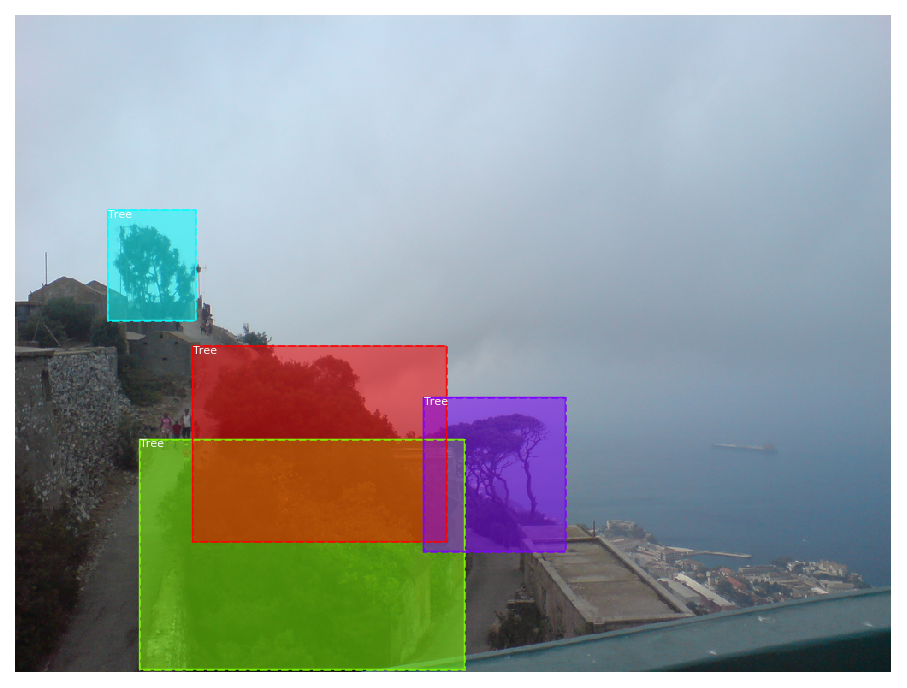

In [10]:
# two build-in functions
from mrcnn.utils import extract_bboxes
from mrcnn.visualize import display_instances

image_id = 18056
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)
bbox = extract_bboxes(mask) # build-in function bbox=bounding box
display_instances(image,bbox,mask,class_ids,train_set.class_names)

In [11]:
#############################################################################################
#Train
#############################################################################################

In [12]:
from mrcnn.config import Config
# define a configuration for the model
class OpenImageConfig(Config):
    # GIve the configutation a recognizable name
    NAME = "OpenImage_cfg"
    #Number of classes 
    NUM_CLASSES = 1 + len(class_file)
    #Number of training steps per epoch
    # here, the number shows how many images you use in one "epoch"
    # but epoch here is not same to the "epoch" = used all the dataset once
    # it just for the information in keras that give you one feedback
    STEPS_PER_EPOCH = 1000
    
    
    #see https://github.com/matterport/Mask_RCNN/issues/921 
    # issue I met when setting GPU_COUNT > 1 => midify the code
    # see https://github.com/matterport/Mask_RCNN/issues/875
    # why more GPUs will be slower? => batch size = GPU_COUNT*IMAGES_PER_GPU 
    # each "epoch" process batch_size*STEPS_PER_EPCOH images
    GPU_COUNT = 3
    IMAGES_PER_GPU = 2
    
config = OpenImageConfig()

In [13]:
from mrcnn.model import MaskRCNN
# define the model
model = MaskRCNN(mode='training',model_dir='./',config = config)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Using TensorFlow backend.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


In [14]:
# load weights (mscoco, downloaded)
# clss-specific output layers are removed by 'exclude' argument
model.load_weights('mask_rcnn_coco.h5',by_name=True,exclude=["mrcnn_class_logits","mrcnn_bbox_fc","mrcnn_bbox","mrcnn_mask"])

In [15]:
# train the model (output layers or 'heads')
# it seems that the original code cannot run with the latest keras 
# see https://github.com/matterport/Mask_RCNN/issues/1754 
# replace self.keras_model.metrics_tensors.append(loss)
# by self.keras_model.add_metric(loss, name)
#line 2199 in model.py
model.train(train_set,test_set,learning_rate=config.LEARNING_RATE,epochs=300,layers='heads')

# 40 epochs total_image_trained = 40 epochs * 1000steps_per_epoch*3 GPUS * 2images per gpu
# = 240000
# true epcoh 240000/80000 = 3


Starting at epoch 0. LR=0.001

Checkpoint Path: ./openimage_cfg20191129T1045/mask_rcnn_openimage_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4       

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/300
1000/1000 [==============================] - 1058s 1s/step - loss: 1.9510 - rpn_class_loss: 0.0745 - rpn_bbox_loss: 0.4775 - mrcnn_class_loss: 0.6325 - mrcnn_bbox_loss: 0.3657 - mrcnn_mask_loss: 0.4009 - val_loss: 2.6580 - val_rpn_class_loss: 0.2855 - val_rpn_bbox_loss: 1.5279 - val_mrcnn_class_loss: 0.9800 - val_mrcnn_bbox_loss: 0.5166 - val_mrcnn_mask_loss: 0.5383

Epoch 2/300
1000/1000 [==============================] - 1305s 1s/step - loss: 1.7709 - rpn_class_loss: 0.0792 - rpn_bbox_loss: 0.5097 - mrcnn_class_loss: 0.5268 - mrcnn_bbox_loss: 0.3117 - mrcnn_mask_loss: 0.3434 - val_loss: 2.5364 - val_rpn_class_loss: 0.1367 - val_rpn_bbox_loss: 0.7130 - val_mrcnn_class_loss: 0.8253 - val_mrcnn_bbox_loss: 0.4754 - val_mrcnn_mask_loss: 0.3648
Epoch 3/300
1000/1000 [==============================] - 1359s 1s/step - loss: 1.5492 - rpn_class_loss: 0.0701 - rpn_bbox_loss: 0.4465 - mrcnn_class_loss: 0.4360 - mrcnn_bbox_loss: 0.2737 - mrcnn_mask_loss: 0.3230 - val_loss: 2.5100 - va

1000/1000 [==============================] - 1214s 1s/step - loss: 1.2655 - rpn_class_loss: 0.0562 - rpn_bbox_loss: 0.3741 - mrcnn_class_loss: 0.3547 - mrcnn_bbox_loss: 0.2176 - mrcnn_mask_loss: 0.2629 - val_loss: 2.3905 - val_rpn_class_loss: 0.0830 - val_rpn_bbox_loss: 0.7686 - val_mrcnn_class_loss: 0.7633 - val_mrcnn_bbox_loss: 0.4844 - val_mrcnn_mask_loss: 0.3201
Epoch 23/300
1000/1000 [==============================] - 1206s 1s/step - loss: 1.2112 - rpn_class_loss: 0.0537 - rpn_bbox_loss: 0.3647 - mrcnn_class_loss: 0.3172 - mrcnn_bbox_loss: 0.2128 - mrcnn_mask_loss: 0.2629 - val_loss: 1.9217 - val_rpn_class_loss: 0.0873 - val_rpn_bbox_loss: 1.0485 - val_mrcnn_class_loss: 0.7229 - val_mrcnn_bbox_loss: 0.4391 - val_mrcnn_mask_loss: 0.2981
Epoch 24/300
1000/1000 [==============================] - 1204s 1s/step - loss: 1.1834 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 0.3702 - mrcnn_class_loss: 0.3081 - mrcnn_bbox_loss: 0.1997 - mrcnn_mask_loss: 0.2568 - val_loss: 2.1250 - val_rpn_class

1000/1000 [==============================] - 1313s 1s/step - loss: 1.2053 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 0.3922 - mrcnn_class_loss: 0.3061 - mrcnn_bbox_loss: 0.2038 - mrcnn_mask_loss: 0.2542 - val_loss: 2.6825 - val_rpn_class_loss: 0.1804 - val_rpn_bbox_loss: 0.8910 - val_mrcnn_class_loss: 0.9356 - val_mrcnn_bbox_loss: 0.4093 - val_mrcnn_mask_loss: 0.3180
Epoch 44/300
1000/1000 [==============================] - 1314s 1s/step - loss: 1.1844 - rpn_class_loss: 0.0553 - rpn_bbox_loss: 0.3612 - mrcnn_class_loss: 0.3119 - mrcnn_bbox_loss: 0.2003 - mrcnn_mask_loss: 0.2557 - val_loss: 2.6303 - val_rpn_class_loss: 0.2049 - val_rpn_bbox_loss: 0.9162 - val_mrcnn_class_loss: 0.9226 - val_mrcnn_bbox_loss: 0.4660 - val_mrcnn_mask_loss: 0.3336
Epoch 45/300
1000/1000 [==============================] - 1331s 1s/step - loss: 1.1146 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 0.3410 - mrcnn_class_loss: 0.2893 - mrcnn_bbox_loss: 0.1908 - mrcnn_mask_loss: 0.2445 - val_loss: 2.7619 - val_rpn_class

1000/1000 [==============================] - 1390s 1s/step - loss: 1.1667 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 0.3716 - mrcnn_class_loss: 0.2983 - mrcnn_bbox_loss: 0.1980 - mrcnn_mask_loss: 0.2499 - val_loss: 2.9477 - val_rpn_class_loss: 0.0852 - val_rpn_bbox_loss: 0.7260 - val_mrcnn_class_loss: 0.7086 - val_mrcnn_bbox_loss: 0.4652 - val_mrcnn_mask_loss: 0.3093
Epoch 65/300
1000/1000 [==============================] - 1401s 1s/step - loss: 1.1428 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 0.3331 - mrcnn_class_loss: 0.3192 - mrcnn_bbox_loss: 0.1972 - mrcnn_mask_loss: 0.2501 - val_loss: 2.1666 - val_rpn_class_loss: 0.0785 - val_rpn_bbox_loss: 0.8997 - val_mrcnn_class_loss: 0.6182 - val_mrcnn_bbox_loss: 0.4533 - val_mrcnn_mask_loss: 0.3059
Epoch 66/300
1000/1000 [==============================] - 1351s 1s/step - loss: 1.1399 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 0.3555 - mrcnn_class_loss: 0.3071 - mrcnn_bbox_loss: 0.1911 - mrcnn_mask_loss: 0.2380 - val_loss: 2.9473 - val_rpn_class

1000/1000 [==============================] - 1254s 1s/step - loss: 1.1572 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 0.3927 - mrcnn_class_loss: 0.2861 - mrcnn_bbox_loss: 0.1914 - mrcnn_mask_loss: 0.2410 - val_loss: 2.7863 - val_rpn_class_loss: 0.0847 - val_rpn_bbox_loss: 0.8408 - val_mrcnn_class_loss: 0.6881 - val_mrcnn_bbox_loss: 0.3909 - val_mrcnn_mask_loss: 0.3008
Epoch 86/300
1000/1000 [==============================] - 1241s 1s/step - loss: 1.0546 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 0.3345 - mrcnn_class_loss: 0.2700 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.2289 - val_loss: 1.9316 - val_rpn_class_loss: 0.1154 - val_rpn_bbox_loss: 0.8052 - val_mrcnn_class_loss: 0.7381 - val_mrcnn_bbox_loss: 0.3723 - val_mrcnn_mask_loss: 0.3045
Epoch 87/300
1000/1000 [==============================] - 1231s 1s/step - loss: 1.1848 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 0.3838 - mrcnn_class_loss: 0.3010 - mrcnn_bbox_loss: 0.2042 - mrcnn_mask_loss: 0.2471 - val_loss: 2.1487 - val_rpn_class

1000/1000 [==============================] - 1201s 1s/step - loss: 1.0624 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 0.3451 - mrcnn_class_loss: 0.2756 - mrcnn_bbox_loss: 0.1741 - mrcnn_mask_loss: 0.2286 - val_loss: 2.4403 - val_rpn_class_loss: 0.1286 - val_rpn_bbox_loss: 0.9730 - val_mrcnn_class_loss: 0.6557 - val_mrcnn_bbox_loss: 0.3940 - val_mrcnn_mask_loss: 0.3414
Epoch 107/300
1000/1000 [==============================] - 1213s 1s/step - loss: 1.0330 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 0.3005 - mrcnn_class_loss: 0.2760 - mrcnn_bbox_loss: 0.1800 - mrcnn_mask_loss: 0.2356 - val_loss: 1.7402 - val_rpn_class_loss: 0.1836 - val_rpn_bbox_loss: 1.0957 - val_mrcnn_class_loss: 0.6456 - val_mrcnn_bbox_loss: 0.4088 - val_mrcnn_mask_loss: 0.3147
Epoch 108/300
1000/1000 [==============================] - 1220s 1s/step - loss: 1.0904 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 0.3402 - mrcnn_class_loss: 0.2828 - mrcnn_bbox_loss: 0.1880 - mrcnn_mask_loss: 0.2377 - val_loss: 2.4869 - val_rpn_cla

1000/1000 [==============================] - 1300s 1s/step - loss: 1.0559 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 0.3133 - mrcnn_class_loss: 0.2885 - mrcnn_bbox_loss: 0.1794 - mrcnn_mask_loss: 0.2314 - val_loss: 2.4325 - val_rpn_class_loss: 0.2327 - val_rpn_bbox_loss: 1.1949 - val_mrcnn_class_loss: 0.7263 - val_mrcnn_bbox_loss: 0.4160 - val_mrcnn_mask_loss: 0.3146
Epoch 128/300
1000/1000 [==============================] - 1287s 1s/step - loss: 1.1279 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 0.3661 - mrcnn_class_loss: 0.2906 - mrcnn_bbox_loss: 0.1842 - mrcnn_mask_loss: 0.2369 - val_loss: 2.3949 - val_rpn_class_loss: 0.1901 - val_rpn_bbox_loss: 1.0954 - val_mrcnn_class_loss: 0.7055 - val_mrcnn_bbox_loss: 0.4364 - val_mrcnn_mask_loss: 0.3337
Epoch 129/300
1000/1000 [==============================] - 1278s 1s/step - loss: 1.1153 - rpn_class_loss: 0.0480 - rpn_bbox_loss: 0.3535 - mrcnn_class_loss: 0.2805 - mrcnn_bbox_loss: 0.1894 - mrcnn_mask_loss: 0.2438 - val_loss: 2.6868 - val_rpn_cla

1000/1000 [==============================] - 1265s 1s/step - loss: 1.0766 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 0.3370 - mrcnn_class_loss: 0.2821 - mrcnn_bbox_loss: 0.1805 - mrcnn_mask_loss: 0.2335 - val_loss: 4.0311 - val_rpn_class_loss: 0.1732 - val_rpn_bbox_loss: 1.1332 - val_mrcnn_class_loss: 0.7539 - val_mrcnn_bbox_loss: 0.4221 - val_mrcnn_mask_loss: 0.3484
Epoch 149/300
1000/1000 [==============================] - 1263s 1s/step - loss: 1.1711 - rpn_class_loss: 0.0533 - rpn_bbox_loss: 0.3725 - mrcnn_class_loss: 0.2920 - mrcnn_bbox_loss: 0.2004 - mrcnn_mask_loss: 0.2529 - val_loss: 4.1784 - val_rpn_class_loss: 0.1874 - val_rpn_bbox_loss: 1.2698 - val_mrcnn_class_loss: 0.6877 - val_mrcnn_bbox_loss: 0.4035 - val_mrcnn_mask_loss: 0.3273
Epoch 150/300
1000/1000 [==============================] - 1266s 1s/step - loss: 1.0865 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 0.3381 - mrcnn_class_loss: 0.2890 - mrcnn_bbox_loss: 0.1821 - mrcnn_mask_loss: 0.2339 - val_loss: 2.9516 - val_rpn_cla

1000/1000 [==============================] - 1236s 1s/step - loss: 1.1023 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 0.3441 - mrcnn_class_loss: 0.2879 - mrcnn_bbox_loss: 0.1867 - mrcnn_mask_loss: 0.2382 - val_loss: 1.8577 - val_rpn_class_loss: 0.1083 - val_rpn_bbox_loss: 0.8040 - val_mrcnn_class_loss: 0.7767 - val_mrcnn_bbox_loss: 0.3858 - val_mrcnn_mask_loss: 0.3069
Epoch 170/300
1000/1000 [==============================] - 1241s 1s/step - loss: 1.0704 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 0.3401 - mrcnn_class_loss: 0.2855 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.2296 - val_loss: 2.6191 - val_rpn_class_loss: 0.1382 - val_rpn_bbox_loss: 0.9466 - val_mrcnn_class_loss: 0.6750 - val_mrcnn_bbox_loss: 0.3698 - val_mrcnn_mask_loss: 0.2861
Epoch 171/300
1000/1000 [==============================] - 1242s 1s/step - loss: 1.0504 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 0.3067 - mrcnn_class_loss: 0.2842 - mrcnn_bbox_loss: 0.1822 - mrcnn_mask_loss: 0.2369 - val_loss: 2.9777 - val_rpn_cla

1000/1000 [==============================] - 1289s 1s/step - loss: 1.0617 - rpn_class_loss: 0.0463 - rpn_bbox_loss: 0.3424 - mrcnn_class_loss: 0.2703 - mrcnn_bbox_loss: 0.1785 - mrcnn_mask_loss: 0.2242 - val_loss: 3.3729 - val_rpn_class_loss: 0.1176 - val_rpn_bbox_loss: 0.9238 - val_mrcnn_class_loss: 0.6268 - val_mrcnn_bbox_loss: 0.3389 - val_mrcnn_mask_loss: 0.2976
Epoch 191/300
1000/1000 [==============================] - 1310s 1s/step - loss: 1.0420 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.3173 - mrcnn_class_loss: 0.2806 - mrcnn_bbox_loss: 0.1793 - mrcnn_mask_loss: 0.2286 - val_loss: 2.2743 - val_rpn_class_loss: 0.1703 - val_rpn_bbox_loss: 1.0146 - val_mrcnn_class_loss: 0.6515 - val_mrcnn_bbox_loss: 0.3294 - val_mrcnn_mask_loss: 0.3115
Epoch 192/300
1000/1000 [==============================] - 1318s 1s/step - loss: 1.0899 - rpn_class_loss: 0.0470 - rpn_bbox_loss: 0.3432 - mrcnn_class_loss: 0.2908 - mrcnn_bbox_loss: 0.1791 - mrcnn_mask_loss: 0.2297 - val_loss: 1.8415 - val_rpn_cla

1000/1000 [==============================] - 1272s 1s/step - loss: 1.0528 - rpn_class_loss: 0.0470 - rpn_bbox_loss: 0.3191 - mrcnn_class_loss: 0.2697 - mrcnn_bbox_loss: 0.1838 - mrcnn_mask_loss: 0.2332 - val_loss: 1.8104 - val_rpn_class_loss: 0.1319 - val_rpn_bbox_loss: 0.8558 - val_mrcnn_class_loss: 0.7737 - val_mrcnn_bbox_loss: 0.4088 - val_mrcnn_mask_loss: 0.2866
Epoch 212/300
1000/1000 [==============================] - 1316s 1s/step - loss: 1.1471 - rpn_class_loss: 0.0571 - rpn_bbox_loss: 0.3685 - mrcnn_class_loss: 0.2866 - mrcnn_bbox_loss: 0.1930 - mrcnn_mask_loss: 0.2420 - val_loss: 2.1886 - val_rpn_class_loss: 0.1361 - val_rpn_bbox_loss: 0.8550 - val_mrcnn_class_loss: 0.6973 - val_mrcnn_bbox_loss: 0.3580 - val_mrcnn_mask_loss: 0.2904
Epoch 213/300
1000/1000 [==============================] - 1329s 1s/step - loss: 1.0798 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 0.3573 - mrcnn_class_loss: 0.2692 - mrcnn_bbox_loss: 0.1746 - mrcnn_mask_loss: 0.2350 - val_loss: 2.8191 - val_rpn_cla

1000/1000 [==============================] - 1277s 1s/step - loss: 0.9991 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 0.3135 - mrcnn_class_loss: 0.2567 - mrcnn_bbox_loss: 0.1673 - mrcnn_mask_loss: 0.2206 - val_loss: 2.2194 - val_rpn_class_loss: 0.0980 - val_rpn_bbox_loss: 0.7872 - val_mrcnn_class_loss: 0.8342 - val_mrcnn_bbox_loss: 0.3835 - val_mrcnn_mask_loss: 0.2796
Epoch 233/300
1000/1000 [==============================] - 1267s 1s/step - loss: 1.0886 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 0.3432 - mrcnn_class_loss: 0.2824 - mrcnn_bbox_loss: 0.1838 - mrcnn_mask_loss: 0.2351 - val_loss: 2.0157 - val_rpn_class_loss: 0.0779 - val_rpn_bbox_loss: 0.6596 - val_mrcnn_class_loss: 0.8600 - val_mrcnn_bbox_loss: 0.3771 - val_mrcnn_mask_loss: 0.2797
Epoch 234/300
1000/1000 [==============================] - 1260s 1s/step - loss: 0.9788 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.3108 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.1664 - mrcnn_mask_loss: 0.2202 - val_loss: 2.4061 - val_rpn_cla

1000/1000 [==============================] - 1698s 2s/step - loss: 1.0781 - rpn_class_loss: 0.0463 - rpn_bbox_loss: 0.3190 - mrcnn_class_loss: 0.2942 - mrcnn_bbox_loss: 0.1842 - mrcnn_mask_loss: 0.2343 - val_loss: 2.2114 - val_rpn_class_loss: 0.0879 - val_rpn_bbox_loss: 0.7046 - val_mrcnn_class_loss: 0.8478 - val_mrcnn_bbox_loss: 0.3478 - val_mrcnn_mask_loss: 0.3160
Epoch 254/300
1000/1000 [==============================] - 1719s 2s/step - loss: 1.0416 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 0.3378 - mrcnn_class_loss: 0.2617 - mrcnn_bbox_loss: 0.1749 - mrcnn_mask_loss: 0.2259 - val_loss: 3.2110 - val_rpn_class_loss: 0.1691 - val_rpn_bbox_loss: 0.9073 - val_mrcnn_class_loss: 0.8082 - val_mrcnn_bbox_loss: 0.3361 - val_mrcnn_mask_loss: 0.2965
Epoch 255/300
1000/1000 [==============================] - 1679s 2s/step - loss: 0.9913 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.3105 - mrcnn_class_loss: 0.2563 - mrcnn_bbox_loss: 0.1686 - mrcnn_mask_loss: 0.2205 - val_loss: 1.9450 - val_rpn_cla

1000/1000 [==============================] - 1451s 1s/step - loss: 1.0507 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 0.3484 - mrcnn_class_loss: 0.2625 - mrcnn_bbox_loss: 0.1756 - mrcnn_mask_loss: 0.2229 - val_loss: 1.5848 - val_rpn_class_loss: 0.0875 - val_rpn_bbox_loss: 0.7276 - val_mrcnn_class_loss: 0.8471 - val_mrcnn_bbox_loss: 0.3936 - val_mrcnn_mask_loss: 0.3274
Epoch 275/300
1000/1000 [==============================] - 1434s 1s/step - loss: 1.0031 - rpn_class_loss: 0.0478 - rpn_bbox_loss: 0.3153 - mrcnn_class_loss: 0.2495 - mrcnn_bbox_loss: 0.1680 - mrcnn_mask_loss: 0.2225 - val_loss: 3.0382 - val_rpn_class_loss: 0.0895 - val_rpn_bbox_loss: 0.9463 - val_mrcnn_class_loss: 0.7244 - val_mrcnn_bbox_loss: 0.3822 - val_mrcnn_mask_loss: 0.3360
Epoch 276/300
1000/1000 [==============================] - 1418s 1s/step - loss: 1.0267 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 0.3284 - mrcnn_class_loss: 0.2615 - mrcnn_bbox_loss: 0.1713 - mrcnn_mask_loss: 0.2232 - val_loss: 3.3082 - val_rpn_cla

1000/1000 [==============================] - 1314s 1s/step - loss: 0.9586 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.2815 - mrcnn_class_loss: 0.2467 - mrcnn_bbox_loss: 0.1691 - mrcnn_mask_loss: 0.2229 - val_loss: 1.7722 - val_rpn_class_loss: 0.1078 - val_rpn_bbox_loss: 0.8044 - val_mrcnn_class_loss: 0.7958 - val_mrcnn_bbox_loss: 0.3748 - val_mrcnn_mask_loss: 0.3267
Epoch 296/300
1000/1000 [==============================] - 1311s 1s/step - loss: 1.0540 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 0.3242 - mrcnn_class_loss: 0.2730 - mrcnn_bbox_loss: 0.1815 - mrcnn_mask_loss: 0.2335 - val_loss: 3.4392 - val_rpn_class_loss: 0.1342 - val_rpn_bbox_loss: 0.8328 - val_mrcnn_class_loss: 0.7524 - val_mrcnn_bbox_loss: 0.3788 - val_mrcnn_mask_loss: 0.3356
Epoch 297/300
1000/1000 [==============================] - 1362s 1s/step - loss: 1.0770 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 0.3446 - mrcnn_class_loss: 0.2703 - mrcnn_bbox_loss: 0.1803 - mrcnn_mask_loss: 0.2321 - val_loss: 2.7499 - val_rpn_cla